<a href="https://colab.research.google.com/github/mittyone/JSCCR-fStageII/blob/main/npj_RSF_vs_COX_final_best_parameters_JSCCR_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install scikit-survival (for Random Survival Forest and survival metrics)
!pip install scikit-survival

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, integrated_brier_score, cumulative_dynamic_auc
from sksurv.util import Surv

# Load the dataset
df = pd.read_excel("JSCCR fStageII.xlsx")
df["event"] = df["Event"].apply(lambda x: 1 if x == 2 else 0)
df["time"] = df["DFS"]

# Feature selection
features = ['Dissection Level', 'Obstruction', 'pDepth', 'gender', 'CEA', 'age', 'Pathology']
X_raw = df[features]
X = pd.get_dummies(X_raw.astype(str), drop_first=True)
y = Surv.from_dataframe("event", "time", df)

# Set RSF parameter grid (after narrowing down from Phase 1)
rsf_param_grid = {
    "n_estimators": [100],               # Fixed (sufficient)
    "max_depth": [5, 10, None],           # Adjust tree depth
    "min_samples_leaf": [1, 5],           # Prevent overfitting
    "max_features": [0.5, 1.0],           # Feature subsampling
    "bootstrap": [True]                   # Fixed for OOB evaluation
}
grid = list(ParameterGrid(rsf_param_grid))  # 3 × 2 × 2 = 12 combinations

# Initialize evaluation records
rsf_results = []
rng = np.random.default_rng(seed=42)

# Phase 2: 100 iterations to stabilize evaluation
for i in range(100):  # ✅ Basis for supporting confidence intervals
    indices = rng.choice(len(X), size=len(X), replace=True)
    oob_mask = ~np.isin(np.arange(len(X)), indices)
    X_train, y_train = X.iloc[indices], y[indices]
    X_oob, y_oob = X.iloc[oob_mask], y[oob_mask]

    if len(X_oob) < 10:
        continue

    best_model = None
    best_cindex = -np.inf

    for params in grid:
        model = RandomSurvivalForest(**params, random_state=0)
        model.fit(X_train, y_train)
        c_index = concordance_index_censored(
            y_oob["event"], y_oob["time"], model.predict(X_oob)
        )[0]
        if c_index > best_cindex:
            best_model = model
            best_cindex = c_index

    # Dynamically generate time_grid based on OOB times
    times_oob = y_oob["time"]
    t_min = np.percentile(times_oob, 5)
    t_max = np.percentile(times_oob, 95)
    t_min = max(t_min, times_oob.min() + 1e-5)
    t_max = min(t_max, times_oob.max() - 1e-5)
    time_grid = np.linspace(t_min, t_max, 50)

    best_model.fit(X_train, y_train)  # Retrain best model

    # ===== Calculate IBS manually =====
    from sksurv.metrics import brier_score
    surv_funcs = best_model.predict_survival_function(X_oob)
    surv_preds = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs])
    _, bs_vals = brier_score(y_train, y_oob, surv_preds, time_grid)
    ibs = np.trapz(bs_vals, time_grid) / (time_grid[-1] - time_grid[0])

    # ===== Calculate AUC =====
    try:
        auc_times, auc_vals = cumulative_dynamic_auc(
            y_train, y_oob, best_model.predict(X_oob), time_grid
        )
        iauc = np.trapz(auc_vals, auc_times) / (auc_times[-1] - auc_times[0])
    except:
        iauc = np.nan

    rsf_results.append({
        "c_index": best_cindex,
        "ibs": ibs,
        "iauc": iauc,
        "model": best_model
    })

# Display
rsf_metrics_df = pd.DataFrame([{k: v for k, v in d.items() if k != "model"} for d in rsf_results])
print(rsf_metrics_df)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.4 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.3
    Uninstalling osqp-1.0.3:
      Successfully uninstalled osqp-1.0.3


<ipython-input-2-a5855b32e9c5>:74: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ibs = np.trapz(bs_vals, time_grid) / (time_grid[-1] - time_grid[0])
<ipython-input-2-a5855b32e9c5>:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  iauc = np.trapz(auc_vals, auc_times) / (auc_times[-1] - auc_times[0])
<ipython-input-2-a5855b32e9c5>:74: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ibs = np.trapz(bs_vals, time_grid) / (time_grid[-1] - time_grid[0])
<ipython-input-2-a5855b32e9c5>:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  iauc = np.trapz(auc_vals, auc_times) / (auc_times[-1] - auc_times[0])
<ipython-input-2-a5855b32e9c5>:7

     c_index       ibs  iauc
0   0.595486  0.085391   NaN
1   0.579819  0.092523   NaN
2   0.565033  0.099068   NaN
3   0.606408  0.084162   NaN
4   0.556920  0.088404   NaN
..       ...       ...   ...
95  0.570463  0.096963   NaN
96  0.568018  0.085848   NaN
97  0.568641  0.096075   NaN
98  0.582461  0.103877   NaN
99  0.594720  0.088768   NaN

[100 rows x 3 columns]


<ipython-input-2-a5855b32e9c5>:74: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ibs = np.trapz(bs_vals, time_grid) / (time_grid[-1] - time_grid[0])
<ipython-input-2-a5855b32e9c5>:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  iauc = np.trapz(auc_vals, auc_times) / (auc_times[-1] - auc_times[0])


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 0] AUC failed: list assignment index out of range
[Loop 0] Final IBS: 0.08480547954238507, Final iAUC: nan


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 1] AUC failed: list assignment index out of range
[Loop 1] Final IBS: 0.09055674794339924, Final iAUC: nan


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 2] AUC failed: list assignment index out of range
[Loop 2] Final IBS: 0.09524223074822499, Final iAUC: nan


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 3] AUC failed: list assignment index out of range
[Loop 3] Final IBS: 0.08398907449121619, Final iAUC: nan


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 4] AUC failed: list assignment index out of range
[Loop 4] Final IBS: 0.08547290445021793, Final iAUC: nan


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 5] AUC failed: list assignment index out of range
[Loop 5] Final IBS: 0.09084586512693424, Final iAUC: nan


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 6] AUC failed: list assignment index out of range
[Loop 6] Final IBS: 0.08692164194382203, Final iAUC: nan


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 7] AUC failed: list assignment index out of range
[Loop 7] Final IBS: 0.0981164058290107, Final iAUC: nan


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 8] AUC failed: list assignment index out of range
[Loop 8] Final IBS: 0.08022013844039406, Final iAUC: nan


<ipython-input-3-df57cadf5373>:31: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train, y_train)


[Loop 9] AUC failed: list assignment index out of range
[Loop 9] Final IBS: 0.08402674138182181, Final iAUC: nan

Final Cox Metrics:
 c_index      ibs  iauc
0.604554 0.084805   NaN
0.592291 0.090557   NaN
0.591308 0.095242   NaN
0.612296 0.083989   NaN
0.603656 0.085473   NaN
0.595389 0.090846   NaN
0.629219 0.086922   NaN
0.595547 0.098116   NaN
0.615081 0.080220   NaN
0.610708 0.084027   NaN


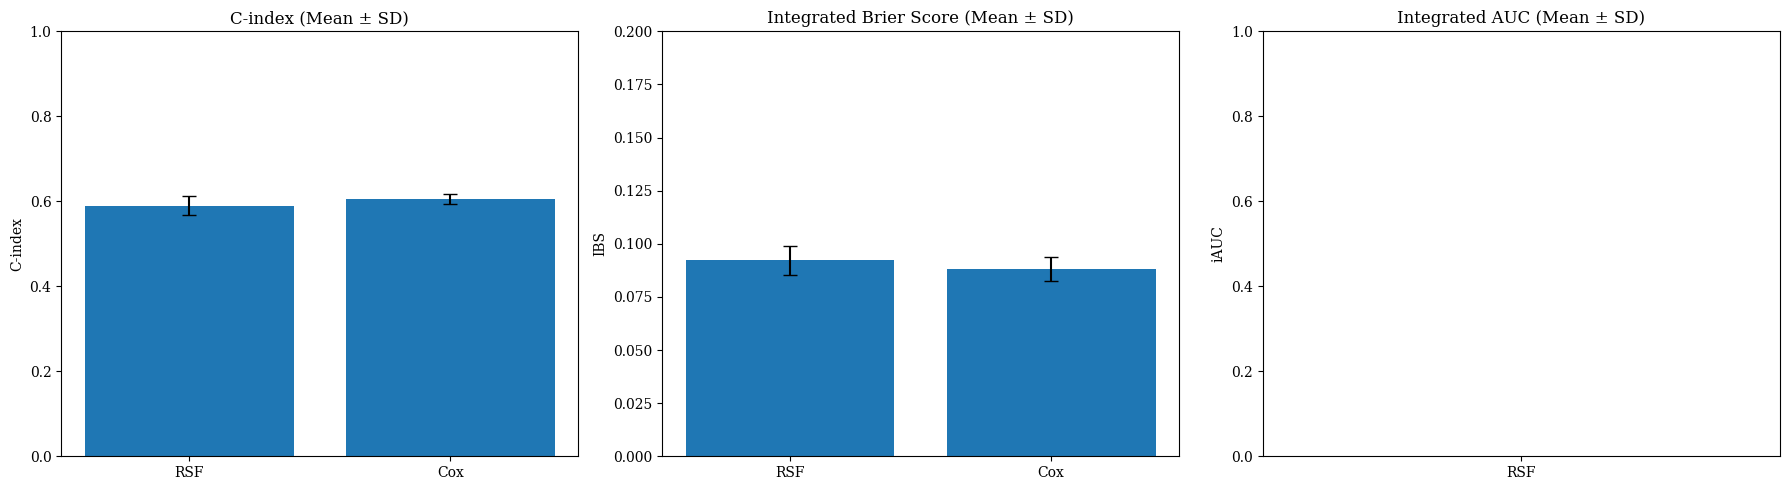

📋 RSF Performance Summary
  C-index: 0.590 ± 0.023
  IBS    : 0.092 ± 0.007
  iAUC   : nan ± nan
----------------------------------------
📋 Cox Performance Summary
  C-index: 0.605 ± 0.012
  IBS    : 0.088 ± 0.006
  iAUC   : nan ± nan
----------------------------------------


In [ ]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, brier_score, cumulative_dynamic_auc
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from numpy import trapezoid  # Alternative to trapz

# Scale features for Cox model
X_scaled = StandardScaler().fit_transform(X)
alphas = [0.001, 0.01, 0.1]

cox_results = []
rng = np.random.default_rng(seed=42)

for i in range(10):
    indices = rng.choice(len(X_scaled), size=len(X_scaled), replace=True)
    oob_mask = ~np.isin(np.arange(len(X_scaled)), indices)
    X_train, y_train = X_scaled[indices], y[indices]
    X_oob, y_oob = X_scaled[oob_mask], y[oob_mask]

    if len(X_oob) < 10:
        continue

    best_model = None
    best_cindex = -np.inf

    for alpha in alphas:
        model = CoxnetSurvivalAnalysis(alphas=[alpha], l1_ratio=1.0, fit_baseline_model=True)

        try:
            model.fit(X_train, y_train)
            pred = model.predict(X_oob)
            c_index = concordance_index_censored(y_oob["event"], y_oob["time"], pred)[0]
            if c_index > best_cindex:
                best_model = model
                best_cindex = c_index
        except Exception as e:
            continue

    if best_model is None:
        continue

    # Generate a safe time_grid
    times_oob = y_oob["time"]
    t_min = np.percentile(times_oob, 5)
    t_max = np.percentile(times_oob, 95)
    t_min = max(t_min, times_oob.min() + 1e-5)
    t_max = min(t_max, times_oob.max() - 1e-5)
    time_grid = np.linspace(t_min, t_max, 50)

    # Calculate IBS
    try:
        surv_funcs = best_model.predict_survival_function(X_oob)
        surv_preds = np.array([[fn(t) for t in time_grid] for fn in list(surv_funcs)])
        if np.isnan(surv_preds).any():
            print(f"[Loop {i}] NaNs in survival predictions. Skipping IBS.")
            ibs = np.nan
        else:
            _, bs_vals = brier_score(y_train, y_oob, surv_preds, time_grid)
            if np.isnan(bs_vals).any():
                print(f"[Loop {i}] NaNs in Brier score. Skipping IBS.")
                ibs = np.nan
            else:
                ibs = trapezoid(bs_vals, time_grid) / (time_grid[-1] - time_grid[0])
    except Exception as e:
        print(f"[Loop {i}] IBS error: {e}")
        ibs = np.nan

    # Calculate AUC
    try:
        risk_scores = best_model.predict(X_oob)
        auc_times, auc_vals = cumulative_dynamic_auc(
            y_train, y_oob, risk_scores, time_grid
        )
        iauc = trapezoid(auc_vals, auc_times) / (auc_times[-1] - auc_times[0])
    except Exception as e:
        print(f"[Loop {i}] AUC failed: {e}")
        iauc = np.nan

    print(f"[Loop {i}] Final IBS: {ibs}, Final iAUC: {iauc}")

    cox_results.append({
        "c_index": best_cindex,
        "ibs": ibs,
        "iauc": iauc,
        "model": best_model
    })

# Display final Cox metrics
cox_metrics_df = pd.DataFrame([{k: v for k, v in d.items() if k != "model"} for d in cox_results])
print("\nFinal Cox Metrics:")
print(cox_metrics_df.to_string(index=False))

import matplotlib.pyplot as plt

# Summarize means and standard deviations
def summarize(df, label):
    return {
        "Model": label,
        "C-index Mean": df["c_index"].mean(),
        "C-index SD": df["c_index"].std(),
        "IBS Mean": df["ibs"].mean(),
        "IBS SD": df["ibs"].std(),
        "iAUC Mean": df["iauc"].mean(),
        "iAUC SD": df["iauc"].std()
    }

# Create a summary DataFrame
summary_df = pd.DataFrame([
    summarize(rsf_metrics_df, "RSF"),
    summarize(cox_metrics_df, "Cox")
])

import matplotlib.pyplot as plt

# Set font to serif
plt.rcParams["font.family"] = "serif"

# ===== Plotting =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# C-index
axes[0].bar(summary_df["Model"], summary_df["C-index Mean"],
            yerr=summary_df["C-index SD"], capsize=5)
axes[0].set_title("C-index (Mean ± SD)")
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("C-index")

# IBS
axes[1].bar(summary_df["Model"], summary_df["IBS Mean"],
            yerr=summary_df["IBS SD"], capsize=5)
axes[1].set_title("Integrated Brier Score (Mean ± SD)")
axes[1].set_ylim(0, 0.2)
axes[1].set_ylabel("IBS")

# iAUC
axes[2].bar(summary_df["Model"], summary_df["iAUC Mean"],
            yerr=summary_df["iAUC SD"], capsize=5)
axes[2].set_title("Integrated AUC (Mean ± SD)")
axes[2].set_ylim(0, 1)
axes[2].set_ylabel("iAUC")

plt.tight_layout()
plt.show()


def summarize_metrics(df, label):
    print(f"📋 {label} Performance Summary")
    print(f"  C-index: {df['c_index'].mean():.3f} ± {df['c_index'].std():.3f}")
    print(f"  IBS    : {df['ibs'].mean():.3f} ± {df['ibs'].std():.3f}")
    print(f"  iAUC   : {df['iauc'].mean():.3f} ± {df['iauc'].std():.3f}")
    print("-" * 40)

# RSF
summarize_metrics(rsf_metrics_df, "RSF")

# Cox
summarize_metrics(cox_metrics_df, "Cox")


        Variable  RSF Importance  Cox Importance (|coef|)
             CEA        0.033546                 0.154169
Dissection Level        0.045778                 0.163219
     Obstruction        0.026811                 0.258140
       Pathology        0.020134                 0.081183
             age        0.028794                 0.141703
          gender        0.048545                 0.215283
          pDepth        0.055306                 0.357316


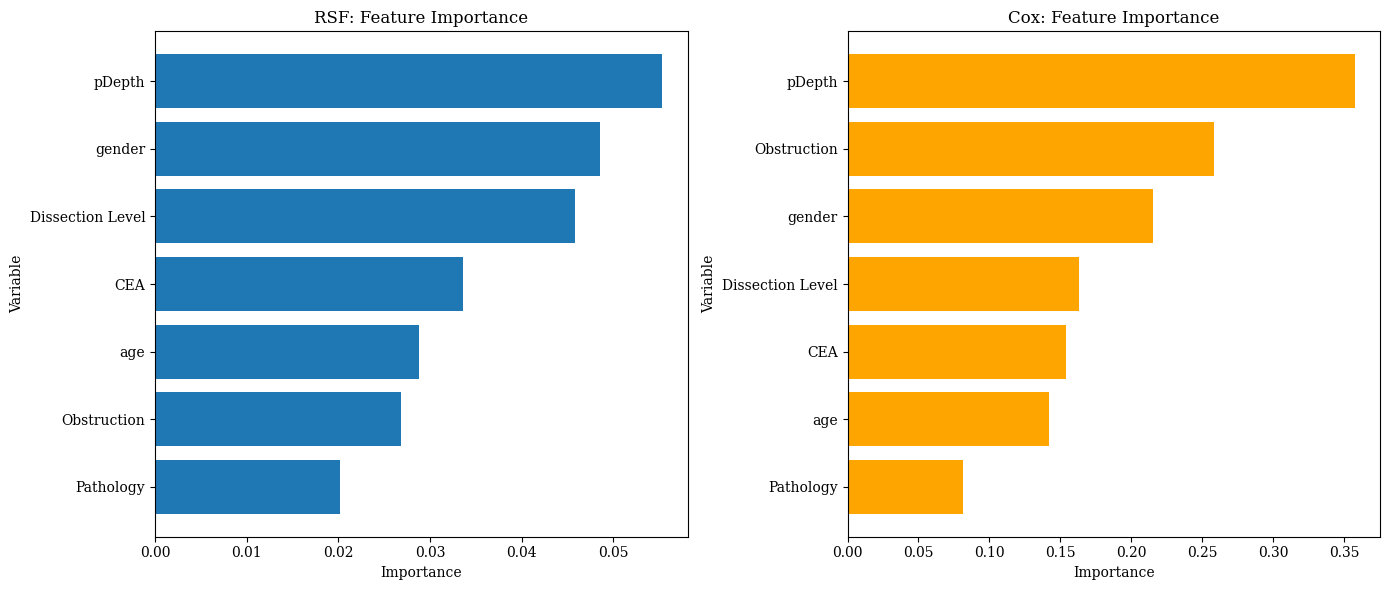

In [ ]:
from sklearn.inspection import permutation_importance

# Retrieve the best RSF model from results
best_rsf_model = rsf_results[-1]["model"]
rsf_model = RandomSurvivalForest(**best_rsf_model.get_params())

# Retrain RSF model on the entire dataset
rsf_model.fit(X, y)

# Define a scoring function based on C-index
def cindex_scorer(model, X_val, y_val):
    pred = model.predict(X_val)
    return concordance_index_censored(y_val["event"], y_val["time"], pred)[0]

# Convert sksurv's Surv format to DataFrame (needed for scoring)
y_df = pd.DataFrame({
    "event": y["event"],
    "time": y["time"]
})

# Compute permutation importance based on C-index
result = permutation_importance(
    rsf_model, X, y_df,
    scoring=cindex_scorer,
    n_repeats=10,
    random_state=42
)

# Create DataFrame for RSF feature importance
rsf_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "RSF Importance": result.importances_mean
}).sort_values("RSF Importance", ascending=False)

# Retrieve the final Cox model (best)
cox_model = cox_results[-1]["model"]

# === Compute Cox feature importance (absolute value of coefficients) ===
cox_coef = np.abs(cox_model.coef_.ravel())
cox_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Cox Importance (|coef|)": cox_coef
})

# === Merge RSF and Cox importances ===
merged_importance_df = pd.merge(
    rsf_importance_df,
    cox_importance_df,
    on="Feature"
).sort_values("RSF Importance", ascending=False)

# Summarize feature importance by variable group
def group_feature_importance(df, method_col):
    # Extract original variable names (e.g., 'Pathology_A' → 'Pathology')
    df["Variable"] = df["Feature"].str.extract(r"^([^_]+)")
    return df.groupby("Variable")[method_col].sum().reset_index()

# Summarize for RSF
rsf_grouped = group_feature_importance(merged_importance_df, "RSF Importance")

# Summarize for Cox
cox_grouped = group_feature_importance(merged_importance_df, "Cox Importance (|coef|)")

# Merge grouped summaries
final_grouped = pd.merge(rsf_grouped, cox_grouped, on="Variable")
print(final_grouped.to_string(index=False))

# Sort for plotting
final_grouped_sorted = final_grouped.sort_values("RSF Importance", ascending=True)

import matplotlib.pyplot as plt

# Set font to serif
plt.rcParams["font.family"] = "serif"


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# RSF feature importance plot
axes[0].barh(final_grouped_sorted["Variable"], final_grouped_sorted["RSF Importance"])
axes[0].set_title("RSF: Feature Importance")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Variable")
axes[0].set_yticks(range(len(final_grouped_sorted)))
axes[0].set_yticklabels(final_grouped_sorted["Variable"])

# Cox feature importance plot
final_grouped_sorted_cox = final_grouped.sort_values("Cox Importance (|coef|)", ascending=True)
axes[1].barh(final_grouped_sorted_cox["Variable"], final_grouped_sorted_cox["Cox Importance (|coef|)"], color='orange')
axes[1].set_title("Cox: Feature Importance")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Variable")
axes[1].set_yticks(range(len(final_grouped_sorted_cox)))
axes[1].set_yticklabels(final_grouped_sorted_cox["Variable"])

plt.tight_layout()
plt.show()
